In [17]:
#pip install -e ../

In [179]:
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent
from aquacrop.utils import prepare_weather
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt


In [180]:
weather_df=prepare_weather("weather_compatible.txt")
suelo_EEMAC = Soil(soil_type='ClayLoam', dz=[.1]*10) # revisar: CN
suelo_EEMAC.cn = 70


In [182]:

class Cultivo:
    def __init__(self, nombre: str, fecha_siembra: str, fecha_cosecha: str = None):
        self.nombre = nombre
        self.fecha_siembra = datetime.strptime(fecha_siembra, "%Y-%m-%d")
        if fecha_cosecha:
            self.fecha_cosecha = datetime.strptime(fecha_cosecha, "%Y-%m-%d")
        else:
            self.fecha_cosecha = self.fecha_siembra + timedelta(days=180)  # valor por defecto
        self.resultado = None

    def simular(self, modelo: AquaCropModel):
        weather_df2 = weather_df.copy()
        weather_df2["Date"] = pd.to_datetime(weather_df2["Date"])

        modelo.sim_start_time = max(self.fecha_siembra - timedelta(days=40),weather_df2["Date"].min().to_pydatetime() + timedelta(days=2)).strftime("%Y/%m/%d")
        modelo.sim_end_time = min(self.fecha_siembra + timedelta(days=160), weather_df2["Date"].max().to_pydatetime() - timedelta(days=2)).strftime("%Y/%m/%d")
        modelo.weather_df = weather_df

        modelo.crop = Crop(self.nombre, planting_date=self.fecha_siembra.strftime("%m/%d"), harvest_date=self.fecha_cosecha.strftime("%m/%d"))
        modelo.run_model(till_termination=True)
        crop_df = modelo.get_crop_growth().copy()
        crop_df = crop_df[crop_df['season_counter']==0]
        water_df = modelo.get_water_storage().copy()
        flux_df = modelo.get_water_flux().copy()

        fecha_inicio=datetime.strptime(modelo.sim_start_time, "%Y/%m/%d")

        # Agregar fechas
        crop_df["Date"] = crop_df["time_step_counter"].apply(lambda x: fecha_inicio + timedelta(days=int(x)))
        water_df["Date"] = water_df["time_step_counter"].apply(lambda x: fecha_inicio + timedelta(days=int(x)))
        flux_df["Date"] = flux_df["time_step_counter"].apply(lambda x: fecha_inicio + timedelta(days=int(x)))

        # Detectar columnas de contenido volumétrico (th1, th2, ...)
        th_columns = [col for col in water_df.columns if col.startswith("th")]
        
        dz_list = modelo.soil.profile[['z_top','zBot']].diff(axis=1).values[:,1]
        
        agua_por_capa = sum(water_df[th] * dz * 1000 for th, dz in zip(th_columns, dz_list))
        water_df["Total_Water_mm"] = agua_por_capa

        self.clima = weather_df2[["Date", "Precipitation"]].rename(columns={"Precipitation": "Prec"}).sort_values("Date").copy()
        self.agua = water_df
        self.agua_flux = flux_df
        self.resultado = crop_df.copy()
        self.fecha_cosecha = crop_df["Date"].max()

    def graficar(self):
        if self.resultado is None:
            raise ValueError("Debe ejecutar simular() antes de graficar.")

        df = pd.merge_asof(self.resultado.sort_values("Date"), self.agua.sort_values("Date"), on="Date")
        df = pd.merge_asof(df.sort_values("Date"), self.agua_flux.sort_values("Date"), on="Date")
        df = pd.merge_asof(df.sort_values("Date"), self.clima.sort_values("Date"), on="Date")
        df = df[df['Date']>self.fecha_siembra]
        
        fig, ax1 = plt.subplots(figsize=(14, 7))
        ax1.plot(df["Date"], df["biomass"]/100, label="Biomasa", color="green", linewidth=2)
        ax1.set_xlabel("Fecha", fontsize=13)
        ax1.set_ylabel("Biomasa (ton/ha)", color="green", fontsize=13)
        ax1.tick_params(axis='y', labelcolor="green")
        
        ax2 = ax1.twinx()
        ax2.plot(df["Date"], df["DryYield"], label="Rendimiento seco", color="orange", linestyle="--", linewidth=2)
        ax2.set_ylabel("Rendimiento seco (ton/ha)", color="orange", fontsize=13)
        ax2.tick_params(axis='y', labelcolor="orange")

        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 60))
        ax3.plot(df["Date"], df["Total_Water_mm"], label="Agua en suelo", color="darkblue", linewidth=2)
        ax3.set_ylabel("Agua total en perfil (mm)", color="darkblue", fontsize=13)
        ax3.tick_params(axis='y', labelcolor="darkblue")

        ax4 = ax1.twinx()
        ax4.spines["right"].set_position(("outward", 120))
        ax4.bar(df["Date"], df["Prec"], width=0.6, label="Precipitación", color="blue", edgecolor="black", alpha=0.7)
        ax4.bar(df["Date"], df["Runoff"], color="red", label="Escorrentía")
        ax4.set_ylabel("Precipitación (mm/día)", color="blue", fontsize=13)
        ax4.tick_params(axis='y', labelcolor="blue")

        lines, labels = [], []
        for ax in [ax1, ax2, ax3, ax4]:
            line, label = ax.get_legend_handles_labels()
            lines += line
            labels += label

        fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(0.05, 0.8), fontsize=11)
        fig.suptitle(f"Evolución de biomasa, rendimiento, agua en el suelo,\nprecipitación y escorrentía {self.nombre.upper()}", fontsize=16, fontweight='bold')
        fig.tight_layout(rect=[0, 0, 1, 0.93])
        ax1.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(rotation=45)
        plt.show()

        df.to_csv(f"{self.nombre.upper()}-{self.fecha_siembra.strftime('%Y')}.csv")

class RotacionCultivo:
    def __init__(self, suelo=suelo_EEMAC, clima=weather_df):
        self.modelo = AquaCropModel(
            sim_start_time="2022/12/01",
            sim_end_time="2023/01/01",
            weather_df=clima,
            soil=suelo,
            crop=Crop("Default", planting_date="01/01"),
            initial_water_content=InitialWaterContent(wc_type="Pct", value=[60])
        )
        self.cultivos = []

    def agregar_cultivo(self, cultivo: Cultivo):
        cultivo.simular(self.modelo)
        self.cultivos.append(cultivo)

    def graficar_todos(self):
        for i, cultivo in enumerate(self.cultivos):
            cultivo.graficar()
            if i < len(self.cultivos) - 1:
                siguiente = self.cultivos[i + 1]
                if siguiente.fecha_siembra > cultivo.fecha_cosecha:
                    self.graficar_barbecho(cultivo, siguiente,
                                           nombre=f"{cultivo.nombre}-{siguiente.nombre}")
    def graficar_barbecho(self, anterior, siguiente, nombre="Barbecho"):
        fecha_inicio = anterior.fecha_cosecha
        fecha_fin = siguiente.fecha_siembra
    
        # Unir agua + escorrentía + clima
        df = pd.merge_asof(siguiente.agua.sort_values("Date"), siguiente.agua_flux.sort_values("Date"), on="Date")
        df = pd.merge_asof(df.sort_values("Date"), siguiente.clima.sort_values("Date"), on="Date")
    
        # Filtrar solo el rango de barbecho
        df = df[(df["Date"] > fecha_inicio) & (df["Date"] < fecha_fin)]
    
        # Crear gráfico
        fig, ax1 = plt.subplots(figsize=(14, 5))
        agua = df[df["Total_Water_mm"]>10]
        ax1.plot(agua["Date"], agua["Total_Water_mm"], label="Agua en suelo", color="darkblue", linewidth=2)
        ax1.set_ylabel("Agua total en perfil (mm)", color="darkblue", fontsize=13)
        ax1.tick_params(axis='y', labelcolor="darkblue")
        ax1.set_xlabel("Fecha", fontsize=13)
    
        # Eje secundario para precipitación y escorrentía
        ax2 = ax1.twinx()
        ax2.bar(df["Date"], df["Prec"], width=0.6, label="Precipitación", color="blue", edgecolor="black", alpha=0.5)
        ax2.bar(df["Date"], df["Runoff"], width=0.6, label="Escorrentía", color="red", alpha=0.5)
        ax2.set_ylabel("Precipitación / Escorrentía (mm/día)", color="blue", fontsize=13)
        ax2.tick_params(axis='y', labelcolor="blue")
    
        # Leyenda combinada
        lines, labels = [], []
        for ax in [ax1, ax2]:
            l, lab = ax.get_legend_handles_labels()
            lines += l
            labels += lab
        fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(0.05, 0.85), fontsize=11)
    
        fig.suptitle(f"Periodo de barbecho: {nombre} ({fecha_inicio.date()} → {fecha_fin.date()})", fontsize=15, fontweight='bold')
        ax1.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(rotation=45)
        plt.show()

        df.to_csv(f"B{nombre.upper()}-{anterior.fecha_cosecha.strftime('%Y')}.csv")

        print(f"Suma de escorrentia barbecho: {df['Runoff'].sum()}")
        

        
    


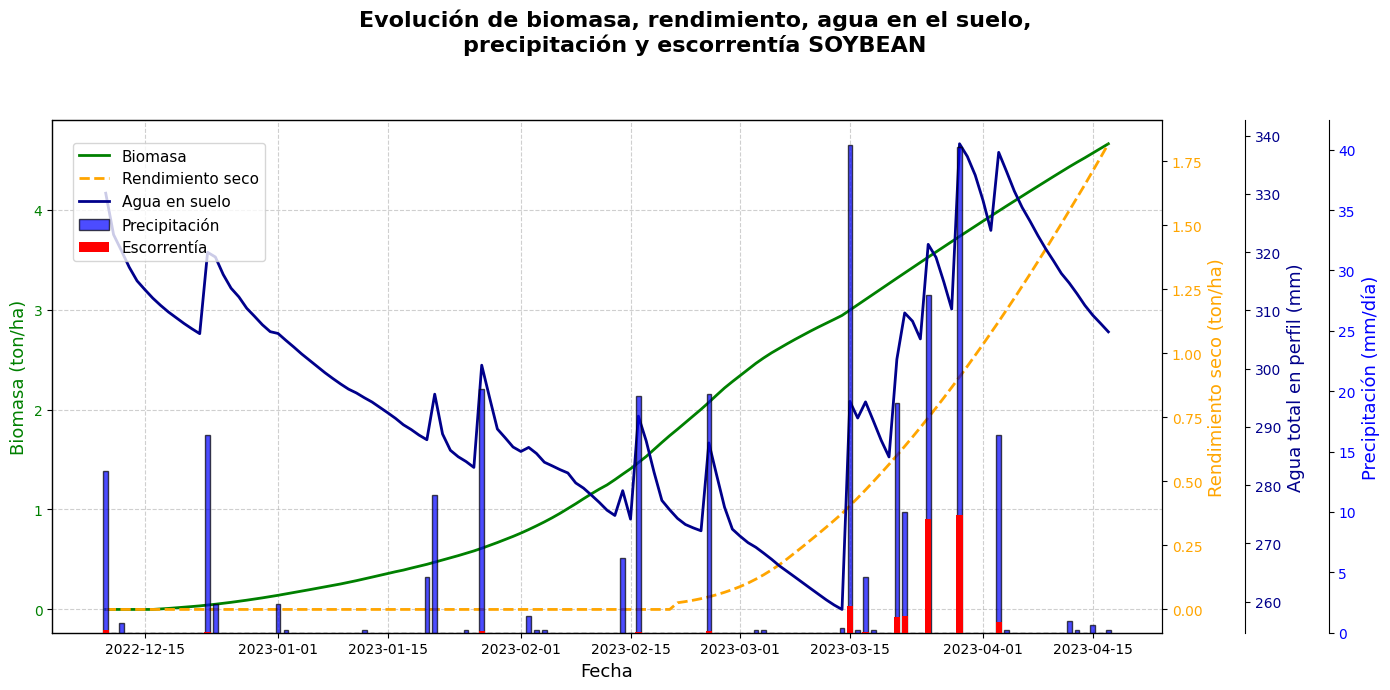

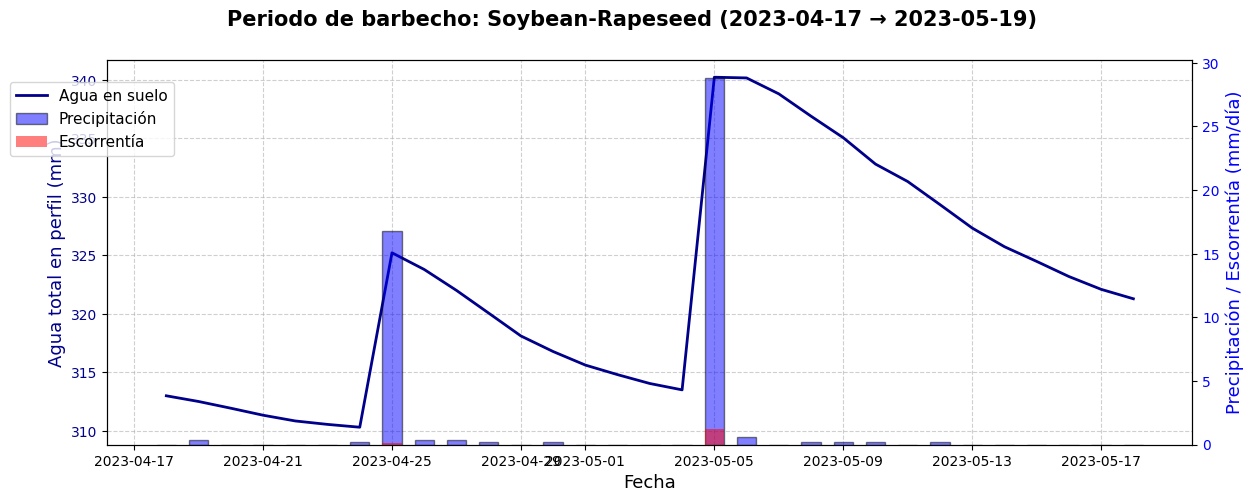

Suma de escorrentia barbecho: 1.3997406503573242


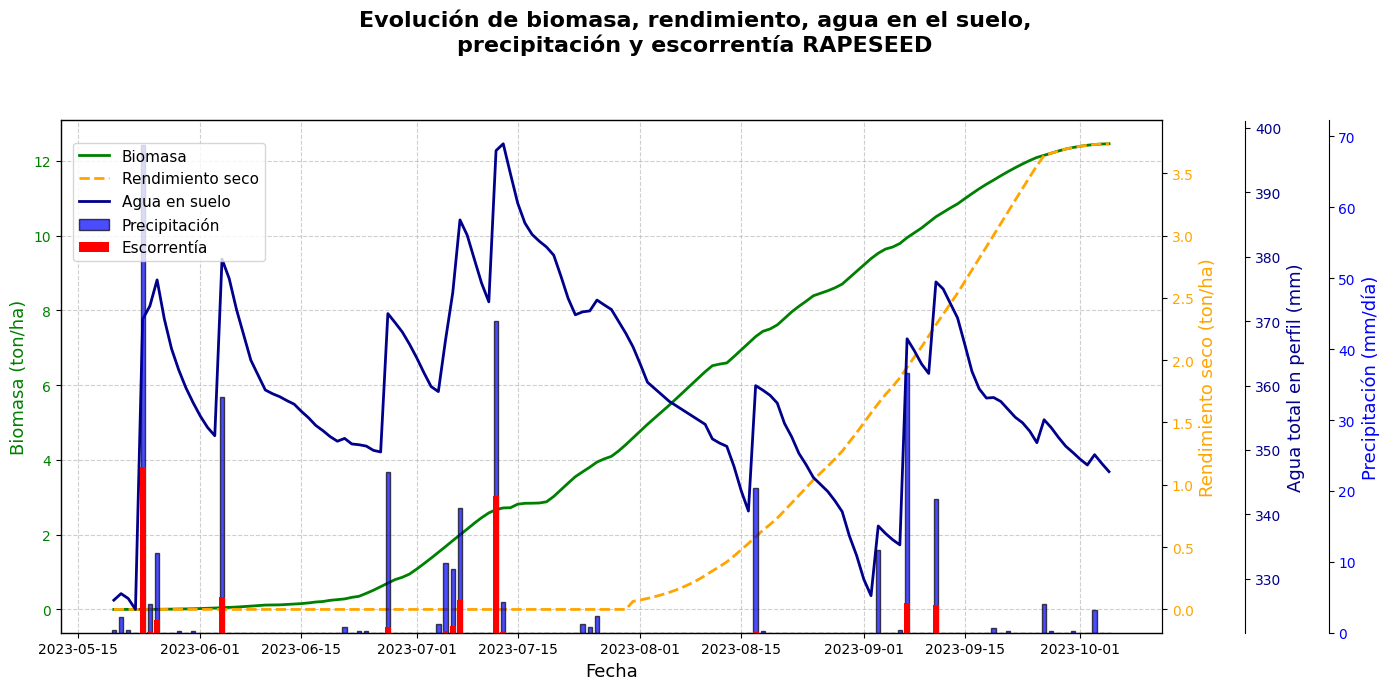

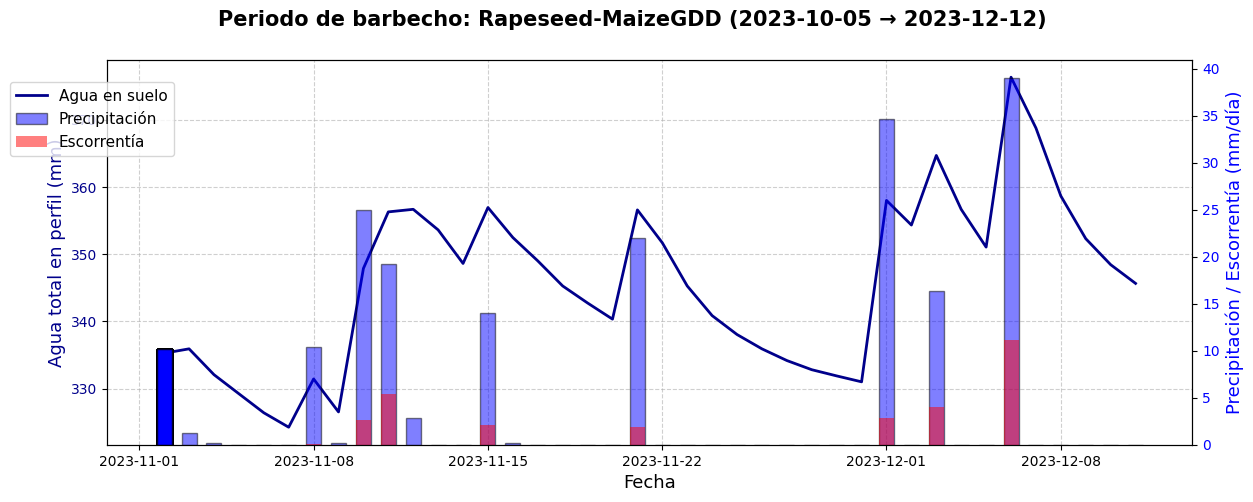

Suma de escorrentia barbecho: 30.123914603203296


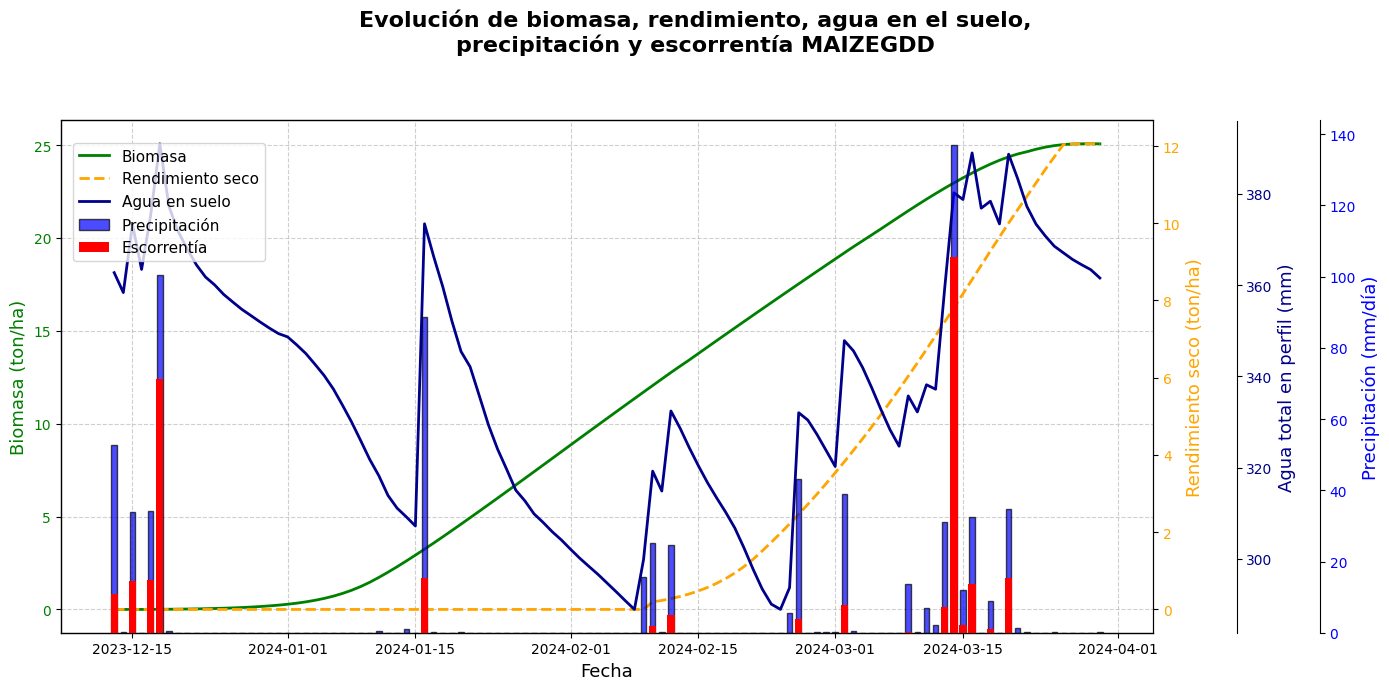

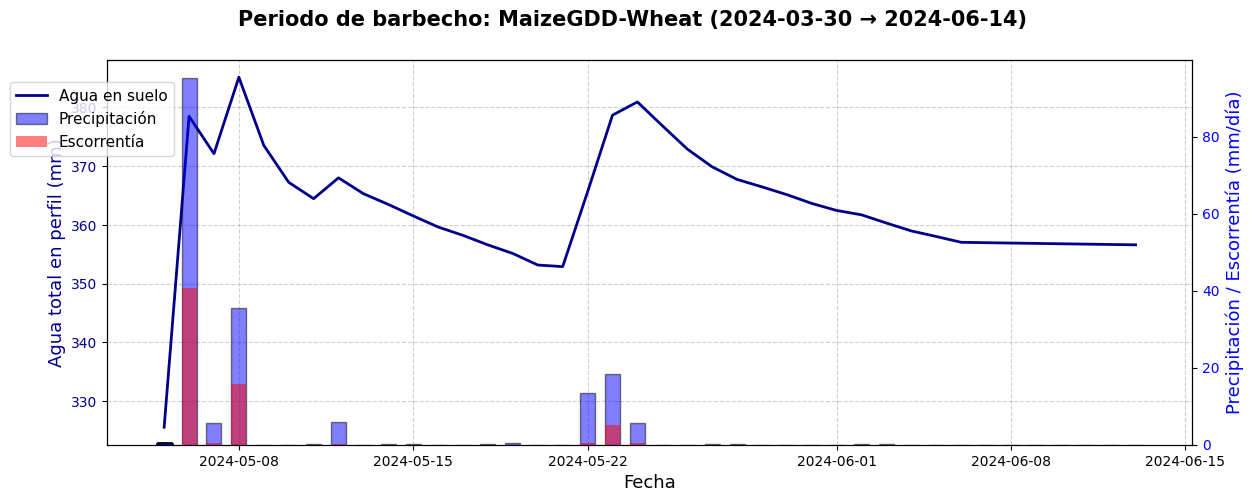

Suma de escorrentia barbecho: 62.76800363474516


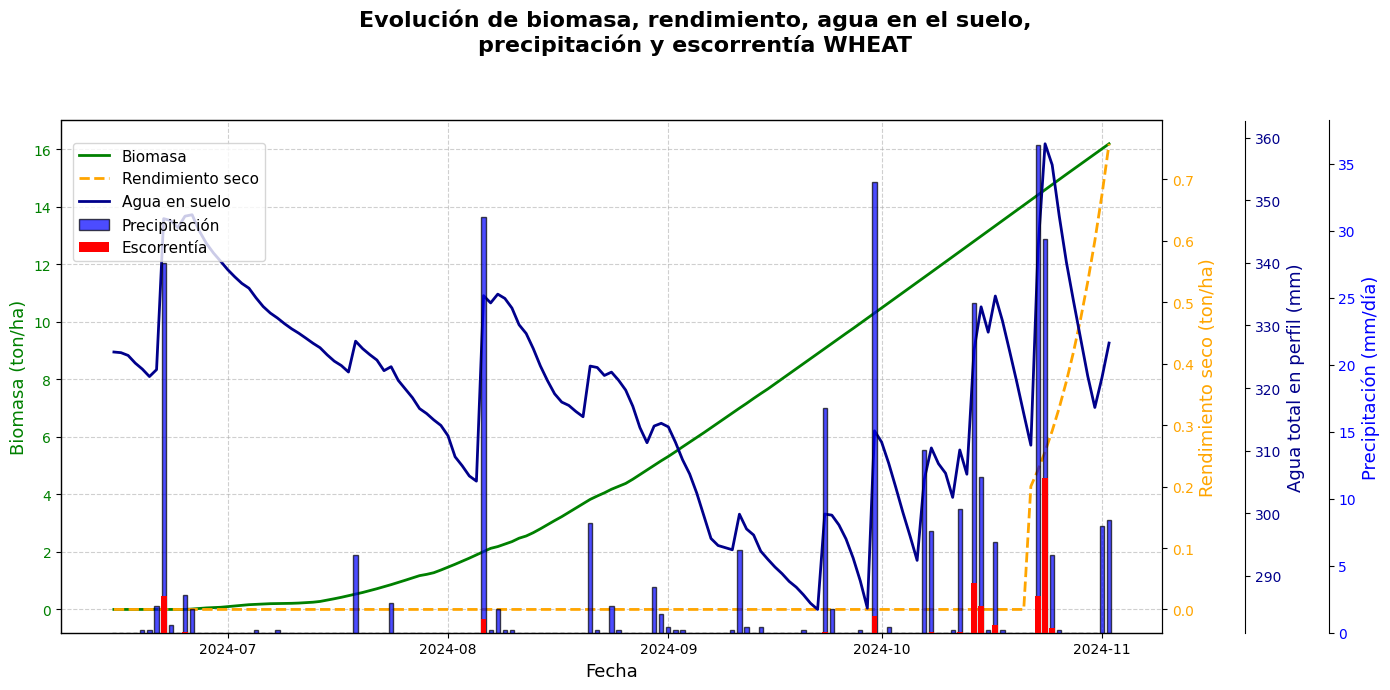

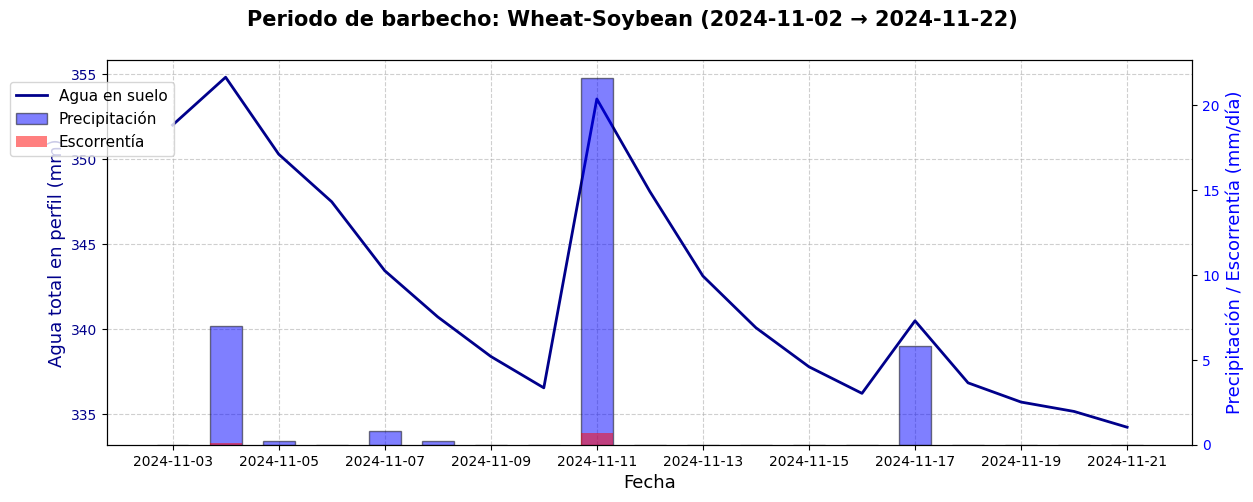

Suma de escorrentia barbecho: 0.8168449784638427


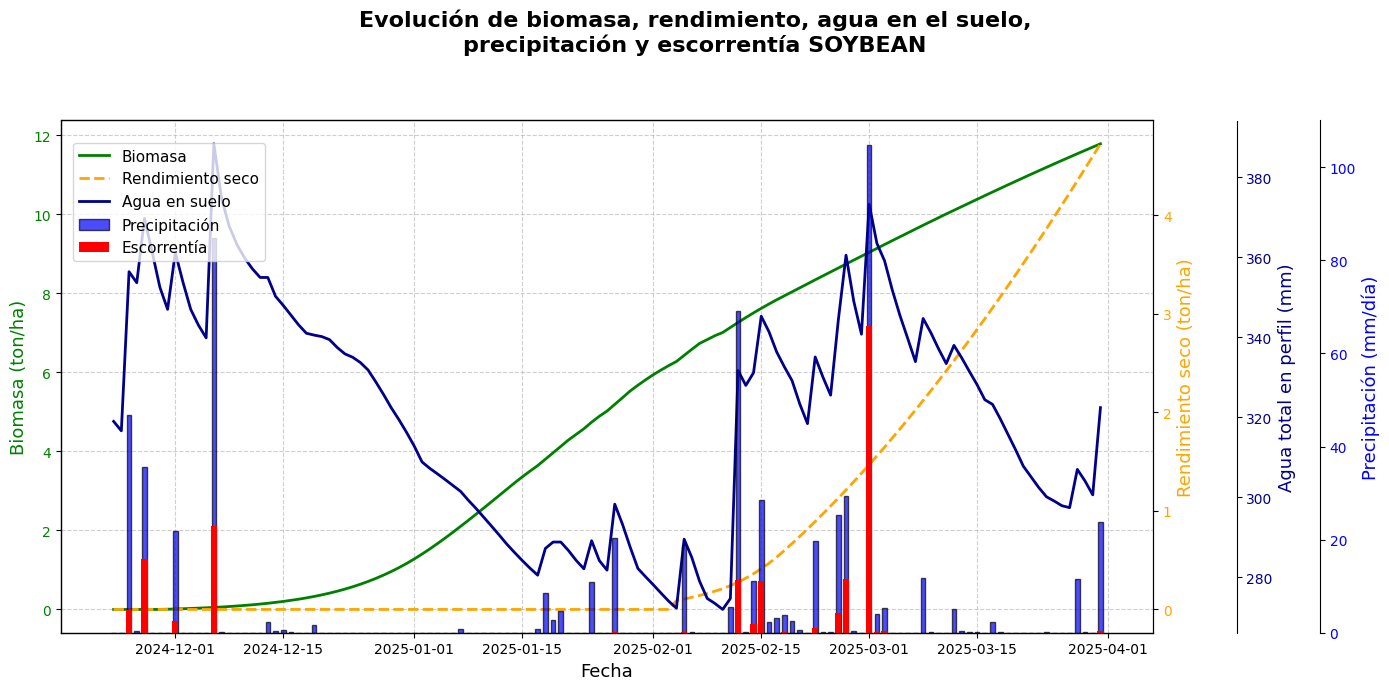

In [183]:
rotacion = RotacionCultivo(clima=weather_df)

soja_22 = Cultivo("Soybean", "2022-12-09")
rotacion.agregar_cultivo(soja_22)

colza_23 = Cultivo("Rapeseed", "2023-05-19")
rotacion.agregar_cultivo(colza_23)

maiz_23 = Cultivo("MaizeGDD", "2023-12-12")
rotacion.agregar_cultivo(maiz_23)

avena_24 = Cultivo("Wheat", "2024-06-14", "2024-11-03")
rotacion.agregar_cultivo(avena_24)

soja_24 = Cultivo("Soybean", "2024-11-22")
rotacion.agregar_cultivo(soja_24)

rotacion.graficar_todos()